# ESR Workshop: Examining "peak heat" during historical heatwaves. 

## Introduction

In this guided practical work you will be characterising a deadly heatwave and playing a detective to diagnose its drivers. The end result should be a brief PowerPoint presentation that you will provide to the group, providing a forensic "anatomy" of the heatwave. Your assessment should cover the items listed in the Objectives (below), which can be achieved by following all the instructions provided in this notebook. Make sure you read everything carefully and **ask if you are unsure** (via live messaging with Tom). 

### Objectives

1. Identify a deadly heatwave from history 
2. Characterise the deadly heat wave in terms of its temperature and humidity
3. Explain the drivers of the extreme heat event using Lagrangian methods


### Data

You can read all about the HadISD product here: https://www.metoffice.gov.uk/hadobs/hadisd/. Briefly, it is a global, sub-daily and quality-controlled dataset based on the integrated surface database (https://www.ncdc.noaa.gov/isd).  


### Using this 'notebook'

This 'notebook' is made up of text cells (like this one) and code cells (like the one below). The code cells can be 'run' by first clicking in that cell with your mouse, and then pressing the 'ctrl' key and the 'enter' key at the same time. This causes the python interpreter to read and execute the code. Note that you can also run a code cell by clicking in it, and then clicking on the 'run' icon at the top of this browser window.  

You should follow this notebook by reading the text cells, and running the code cells -- but only when you come to them. The notebook is like a story, and they code should be run at the 'right' time to make sense. 

Note that there are also 'comments' (denoted with the '#' character) in the code cells to draw attention to what each section is doing. Please read the comments carefully to help you understand.


## Instructions

To get started, then, run the code cell below. It sets up our analysis session by importing relevant python 'modules' and defining useful functions. Note that most of these functions are used to calculate humid heat measures from the raw weather station observations.  

**NB: to 'run' the code cell, you just need to click in it with your mouse, and then press the 'ctrl' key and the 'enter' key at the same time.**


In [48]:
# This cell imports the necessary modules, and then defines functions that we will need later on.  
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, pandas as pd
import datetime
import gzip
import netCDF4
import shutil
import requests
import warnings
warnings.filterwarnings('ignore')

# Function to compute the saturation vapour pressure 
def satvp(t):
    
    """
    Function computes the saturation vapour pressure (Pa) for 
    a given temperature (Celsius). This is a simple empirical 
    approximation taken from Huang (2018) [https://doi.org/10.1175/JAMC-D-17-0334.1]
    equations 17 and 18. 
    
    Input(s):
    
    t - temperature (C)
    
    Output(s):
    
    svp - saturation vapour pressure (Pa) 
    
    NOTE: No error checking is performed (e.g., K/F units in t not checked for)
    """
    posidx=t>0
    negidx=t<=0
    svp=np.zeros(len(t))
    svp[posidx]=np.exp(34.494-4924.99/(t[posidx]+237.1))/((t[posidx]+105)**1.57)
    svp[negidx]=np.exp(43.494-6545.8/(t[negidx]+278))/((t[negidx]+868)**2.)
    
    return svp
        
    
def dew_rh(t,d):
    
    """
    Function computes the relative humidity from temperature and 
    dewpoint temperature. 
    
    The function divides computes the saturation vapour pressure
    evaluated at the dewpoint (dvp) and divides this by the saturation 
    vapour pressure evaluated at the air temperature (tvp)
    
    Input(s):
    
    t - temperature (array, C)
    d - dewpoint temperature (array, C)
    
    Output(s):
    
    rh - relative humidity (array, %)
    
    NOTE: No error checking is performed (e.g., K/F units in t/d not checked for)
    """    
    
    rh=satvp(d)/satvp(t)
    rh[rh>1]=1
    rh*=100. 
    return rh

def wetbulb_stull(t,rh):
    
    """
    Function approximates the wetbulb temperature empirically using the 
    relative humidity and air temperature. 
    
    This empirical approximation is taken from Stull (2011) [doi.org/10.1175/JAMC-D-11-0143.1]
    eq. 1
    
    Input(s):
    
    t - temperature (array,C)
    rh - relative humidity (array,%)
    
    Output(s):
    
    tw - wetbulb temperature (array, C)
    
    NOTES: 
    
    No error checking is performed (e.g., K/F units in t not checked for; 
    % for rh not checked)
    
    Formula is strictly only valid for pressures near 1013 hPa; should not be 
    applied to high elevations. 
    """     
    expo=3./2.
    tw=t*np.arctan(0.151977*(rh+8.313659)**0.5)+np.arctan(t+rh)-np.arctan(rh-1.676331)+\
    0.00391838*rh**expo*np.arctan(0.023101*rh)-4.686035
    
    return tw

def wetbulb_globe_temperature(t,rh):
    
    """
    This function computes the wet bulb globe temperature (wbgt). It is a convenience 
    function, really -- calling the functions above to compute the wbgt as a function
    of air temperature and relative humidity
    
    The formula for the wet bulb globe temperature is: 
    
    wbgt = 0.7 * tw + 0.3 * gt
    
    where tw is the wetbulb temperature, and gt is the globe temperature. We make use of 
    A common approximation here: assuming that the globe temperature is equal to the drybulb
    temperature. This is most appropriate out of direct sunlight, as the mean radiant
    temperature approaches the air temperature. 
    
    Input(s):
    
    t - temperature (array,C)
    rh - relative humidity (array,%)
    
    Output(s):
    
    wbgt - wetbulb globe temperature 
    
    NOTES: 
    
    No error checking is performed (e.g., K/F units in t not checked for; % not checked instead of 
    decimal in rh)
    
    """
    tw=wetbulb_stull(t,rh)
    wbgt=0.7*tw+0.3*t
    
    return wbgt

def distance(lat1,lng1,lat2,lng2,miles=False):
    
    """ 
    Calculate the great-circle distance bewteen two points on the Earth surface.

    Input(s): 
    
    lat1 - latitude of ref point (scalar, degrees N)
    lng1 - longitude of ref point (scalar, degrees E)
    lat2 - latitude of candidate points (array, degrees N)
    lng2 - longitude of candidate points (array, degrees E) 

    Output(s): 
    
    h - distance between candidate points and reference point (array, km or miles)
    
    Notes: 
    
    The default unit is kilometers. Miles can be returned
    if the ``miles`` parameter is set to True.

    """
    R=6378.1370 # equatorial radius of Earth (km)
    
    # convert all latitudes/longitudes from decimal degrees to radians
    lat1=np.radians(lat1); lat2=np.radians(lat2); lng1=np.radians(lng1); 
    lng2=np.radians(lng2)

    # calculate haversine
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * R * np.arcsin(np.sqrt(d))
    if miles:
        return h * 0.621371  # in miles
    else:
        return h  # in kilometers    

## Identifying your target heatwave for analysis

I have processed a sample of events from the [Emergency Database](https://www.emdat.be/), selecting all heatwaves with detailed enough meta-data for you to examine their physical drivers (i.e., identify precisely when and where they occurred). The sample is available for viewing [here](https://docs.google.com/spreadsheets/d/1557Ff-r_fHosjmHk2H-G4nceJfhjqbWjY776x1603yA/edit#gid=0). Please access that spreadsheet and **select a heatwave that you want to study**: note down when and where it occurred. For the latter, you will need to convert the place name in the "Geo Locations" column to a lat/lon coordinate in decimal degrees. Googling is fine for this -- perhaps with some detective work to refine the location and understanding of what happened in the event. For example, the 2015 heatwave in Punjab and Sindh killed many in Karachi -- as revealed by a Google search of "2015 heatwave Sindh". If you were interested in this event, using the lat/lon for Karachi would be the best way to proceed with the analysis. 


## Accessing weather station data during your heatwave

Once you have selected a heatwave to study, we are ready to download weather station data to inspect the heat during the event. We will do this programmatically. 

The code below reads the metadata file (called 'hadisd.csv') which should be saved in the same directory as this notebook. It then computes the distance between a 'query point' and each station, evaluating the great circle distance (defined by the 'distance' function above) between pairs of latitude/longitudes. The closest weather station is then selected, and downloaded as a zip file from the [Met Office website](https://www.metoffice.gov.uk/hadobs/hadisd/), which is subsequently unzipped and read in as a netCDF4 file, before being parsed into a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) called 'recent'. This is a very powerful and convenient format for further analysis. We then check availability of both air temperature and depowint temperature during the heatwave period. Only if there is more then 50 % of data available do we accept the station's record; otherwise we go to the next closest station, and so on until finding a record that is complete enough. 

**In the code below you will need to change the variable 'di' to correspond to the folder you are working in (where the 'hadisd.csv' file should also be saved. You only need to change 'fi' if you have altered the name of the hadisd.csv file.** 

The latitude/longitude you select for query_lat/query_lon will determine which weather station is downloaded from the HadISD archive (i.e., which is the closest match). **You will need to change these to the 'epicentre' of your chosen extreme heat event. 

You will also need to edit hw_st and hw_stp to ensure that we search for the right period. When editing these to reflect *your* heat wave period, please **pay close attention to how the start/stop dates are formatted". 

When you are ready, please edit the relevant code below -- and then run it! If everything works Ok, some output should appear on the screen updating you with progress. 

In [49]:
# In the assignments below, we set the necessary paths and filenames. Read the comments to make sure you change 
# things correctly
# This is the 'base' url for the HadISD archive. All files share this prefix
url_base="https://www.metoffice.gov.uk/hadobs/hadisd/v312_202108p/data/hadisd.3.1.2.202108p_19310101-20210901_"


#************************ 
# CHANGE ME
#************************
di="/home/lunet/gytm3/xclimtwin/DriversofExtremeHeat/" ### NOTE: This should be the name of the directory storing the datafile I provided
fi=di+"hadisd.csv" ### NOTE: This assumes that you did not change the name of any *files* I provided (if you did, 
# change the name of 'hadisd.csv' to reflect that renaming; if you did not, you can leave this line unchanged)

# Here we set our reference point -- I'm choosing Belgrade (44.8 N, 20.5E). Later on, you can change these 
# coordinates to obtain data for other locations, but I cannot guarantee the 'quality' of those data 
# (e.g., might be lots missing)
query_lat=24.86 # ** change for your heatwave location
query_lon=67.00 #  ** change for your heatwave location

# Here we set the beginning/end of the heatwave period
hw_st="2015/06/18" # ** change for your heatwave start
hw_stp="2015/06/24" # ** change for your heatwave end

#************************

# We now read in the file using pandas. 'stations' will then be a pandas 'DataFrame':
stations=pd.read_csv(fi,index_col=0)

# Now we find the distances of all weatehr stations to that point -- add it to the DataFrame
stations["dist"]=distance(query_lat,query_lon,stations["lat"],stations["lon"])

# Now we order the stations in descending order, closest to furthest
stations=stations.sort_values(by="dist")

# Now we try downloading the closest file, checking for completeness of data. Stop when we find the
# closest station with data (at least 50 %) during the heatwave
pc_complete=0
try_no=0
while pc_complete <50:
    closest_id=stations.index[try_no]
    closest_dist=stations.iloc[try_no]["dist"]
    print("\nThe closest station has ID: %s; it is %.1f km from the reference point"%
      (closest_id,closest_dist)) # This prints the ID of the closest station
    print("Obtaining that file now...")
    url_file=url_base+closest_id+".nc.gz" # Here we add in the ID of our station ('closest') to build the full url
    r=requests.get(url_file, allow_redirects=True) # Download with the 'requests' library
    fin=di+closest_id+".nc.gz" # This is the name of our output file -- it is where we will save the download
    open(fin, 'wb').write(r.content) # write to file with name: id.nc.gz
    fout=fin.strip(".gz") # Specify the name of the unzipped file -- same as input, but without the .gz
    # The code below unzips the data and writes it to a new file (with name set by the variable fout)
    with gzip.open(fin, 'rb') as f_in:
        with open(fout, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)            
    print("File saved to %s..."%fout)
    print("Reading data into a pandas DataFrame...")
    data=netCDF4.Dataset(fout) # Open the netcdf file
    time = netCDF4.num2date(data["time"], data["time"].units,
                        calendar=data["time"].calendar).data.astype('datetime64[ns]')
    frame=pd.DataFrame(data={'temp':data["temperatures"],"dew":data["dewpoints"],
                        'press':data["stnlp"]},index=time)
    for f in frame.columns: frame[f].loc[frame[f]<-999]=np.nan # set missing values to NaN 
    fullidx=pd.date_range(start=frame.index[0],end=frame.index[-1],freq='3H') # The data are 3-hourly, but some hours
    # are missing. Resetting the index like this adds in 'empty' rows for the missing hours
    frame=frame.reindex(fullidx)
    sel=frame.loc[np.logical_and(frame.index>hw_st,frame.index<hw_stp)]
    print("Checking completeness...")
    test=sel["dew"]+sel["temp"]; pc_complete=np.sum(~np.isnan(test))/np.float(len(test))*100.
    if pc_complete >=50: print("OK! Enough data -- let's proceed with this station")
    else: print("OK! Not enough data; trying next station...")
        
    try_no+=1 # Try the next closest 
    
print("Data ready for analysis!")


The closest station has ID: 417800-99999; it is 17.1 km from the reference point
Obtaining that file now...
File saved to /home/lunet/gytm3/xclimtwin/DriversofExtremeHeat/417800-99999.nc...
Reading data into a pandas DataFrame...
Checking completeness...
OK! Enough data -- let's proceed with this station
Data ready for analysis!


## Computing humid heat 

We are now ready to use these data to compute humid heat quantities. In the cell below, we apply the functions defined earlier to the air temperature and dewpoint temperature to evaluate: 

1. The relative humidity ('rh'); 
2. The wetbulb air temperature ('tw'); and 
3. The wetbulb globe temperature ('wbgt'). 

These derived quantities are then inserted into the pandas DataFrame. As a sanity check, we will also make a quick plot of tw and wbgt. 

Text(0, 0.5, 'Wetbulb globe temperature ($^{\\circ}$C)')

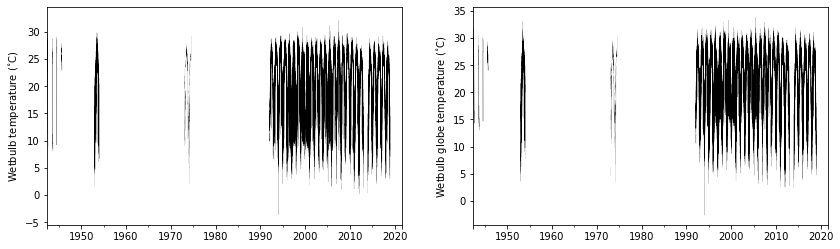

In [50]:
frame["rh"]=dew_rh(frame["temp"],frame["dew"]) # compute the relative humidity
frame["tw"]=wetbulb_stull(frame["temp"],frame["rh"]) # compute the wetbulb temperature
frame["wbgt"]=wetbulb_globe_temperature(frame["temp"],frame["rh"]) # compute the wetbulb globe temperature

# Now plot
fig,ax=plt.subplots(1,2)
fig.set_size_inches(14,4)
frame["tw"].plot(ax=ax.flat[0],color='k',linewidth=0.1)
ax.flat[0].set_ylabel("Wetbulb temperature ($^{\circ}$C)")
frame["wbgt"].plot(ax=ax.flat[1],color='k',linewidth=0.1)
ax.flat[1].set_ylabel("Wetbulb globe temperature ($^{\circ}$C)")

Whilst you may observe some appreciable data gaps in the plots above, the period covering your heatwave should be mostly complete. Let's now study the heat during your chosen extreme event. 

## Characterising the heatwave period

Below we make a plot of the WBGT during the heatwave period (top axes), followed by the temperature and relative humidity (bottom axes) during the extreme. 

Visually compare the WBGT and air temperature. Do they agree on the timing of peak heat stress?

*[Note that your plot may look a bit messy if you picked a long period to define the heatwave]*

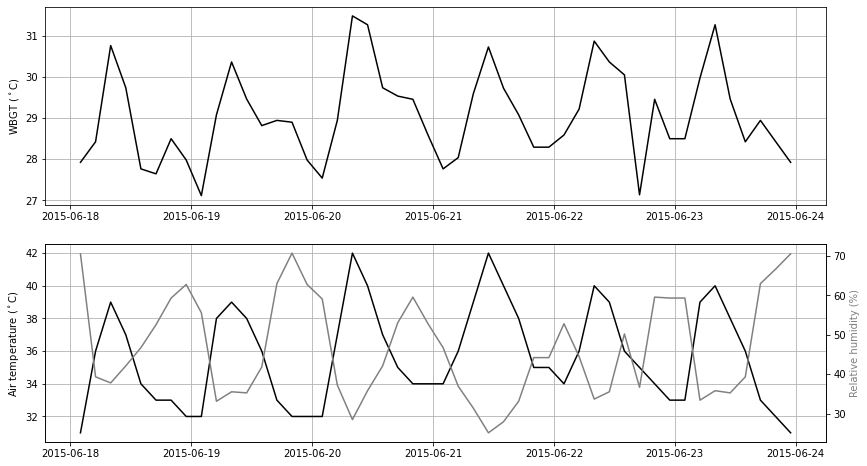

In [51]:
tidx=np.logical_and(frame.index>=hw_st,frame.index<=hw_stp)
sel=frame.loc[tidx]
fig,ax=plt.subplots(2,1)
fig.set_size_inches(14,8)
ax.flat[0].plot(sel.index,sel["wbgt"],color='k')
ax.flat[0].set_ylabel("WBGT (${^\circ}$C)")
ax.flat[1].plot(sel.index,sel["temp"],color='k')
ax.flat[1].set_ylabel("Air temperature (${^\circ}$C)")
ax2=ax.flat[1].twinx()
ax2.plot(sel.index,sel["rh"],color='grey')
ax2.set_ylabel("Relative humidity (%)",color='grey')
ax.flat[0].grid()
ax.flat[1].grid()

Was this a "dry" or "humid" heatwave? We will evaluate this now by finding the temperature and relative humidity during the peak WBGT period.  

In [52]:
sel_max=sel.loc[sel["wbgt"]==sel["wbgt"].max()]
print(sel_max)

                     temp   dew  press         rh         tw       wbgt
2015-06-20 08:00:00  42.0  20.0    NaN  28.495165  26.968322  31.477825


We can now use this peak temperature and relative humidity to estimate the sensible and latent heat content. Calculating how far each of these components was from the long-term mean value will help identify which was more "enhanced" during the extreme event. Run the code below to output the z-scores (standard deviations away from the mean) for the sensible and latent heat components.

*[Note that we make no provision for the seasonal cycle here, so we should expect quite high z scores. A more comprehensive approach would be for us to use a mean and standard deviation that changed with the seasons]*

In [55]:
# Compute approximate H and L
frame["H"]=1004.7*(frame["temp"]+273.15)
frame["L"]=0.622*satvp(frame["dew"])/101300.*2.501*1e6
frame["H_z"]=(frame["H"]-np.nanmean(frame["H"]))/np.nanstd(frame["H"])
frame["L_z"]=(frame["L"]-np.nanmean(frame["L"]))/np.nanstd(frame["L"])

# Figure out z-scores 
sel_max=frame.loc[tidx].loc[sel["wbgt"]==sel["wbgt"].max()]

# Output z-scores. The higher the value, the more unusual!
print("H z-score = %.2f\nL z-score = %.2f"%(sel_max["H_z"],sel_max["L_z"]))

H z-score = 2.71
L z-score = 1.48


## Heatwave drivers

As discussed in the lecture, the 'weather' is always the immediate driver of extreme heat events: clear skies enabling powerful solar heating of the land can pump heat into the boundary layer via the surface heat fluxes; heat can also be advected ("blown in") by favourable winds, with subsidence also possibly amplifying the sensible heat content. Where, then, did the air come from during your selected heatwave? We can assess this now using NOAA's [Hysplit model](https://www.ready.noaa.gov/HYSPLIT.php). The instructions for how to set the model up are provided in [this] Google Doc.

You should follow the instuctions so that you can explain to the group what caused the heat wave. Note that due to constraints with Hysplit, you will have to focus mostly on the sesible heat content; but if the air packets travelled over warm water before reaching the heat wave location -- and if the heatwave was characterised by extreme latent heat content -- it would be reasonable to assume that the journey over warm water could have been an important driver of the extreme event. 

**Remember to direct any questions to Tom if you are unsure about what to do here.** 

## Presenting your findings for discussion

Although you are free to present in any way you like, I suggest the following structure would work: 

- Slide 1: Overview of selected heatwave -- where, when, and impact. 
- Slide 2: Meteorology during the event -- was it a dry or humid heatwave?
- Slide 3 - end (taking as many as you want, but within reason!): Hysplit analysis, with a synthesis/interpretation identifying the main drivers

Good luck!
